<a href="https://colab.research.google.com/github/Mirsha-RG/machine-learning-python-template/blob/main/Coste_seguro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
#!pip install rapidfuzz>NULL

In [58]:
import pandas as pd
import numpy as np
import re
from rapidfuzz import process, fuzz


In [59]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'


In [60]:
df = pd.read_csv(url)
#df.dtypes
#df.info()
df.columns


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [61]:
def columnas_con_tipo_incorrecto(df, tipos_esperados=['float64', 'object', 'int64']):
    columnas_erroneas = []

    for col in df.columns:
        if df[col].dtype.name not in tipos_esperados:
            columnas_erroneas.append(col)


    return columnas_erroneas

columnas_malas = columnas_con_tipo_incorrecto(df)

if columnas_malas:
    print("Estas columnas tienen tipos distintos a float u object:")
    print(columnas_malas)
else:
    print("Todas las columnas tienen tipo float, int u object.")

columnas_con_tipo_incorrecto(df)

Todas las columnas tienen tipo float, int u object.


[]

In [62]:
# estandarizar los strings en todas las variables de tipo object.

def estandarizar_texto(texto):
    """
    Limpia texto usando regex y lo estandariza: minúsculas, sin tildes ni símbolos.
    También convierte algunas etiquetas comunes a np.nan.
    """
    if pd.isnull(texto):
        return np.nan
    texto = str(texto).lower()
    texto = re.sub(r'[\W_]+', ' ', texto)  # elimina símbolos y underscores
    texto = texto.strip()
    if texto in ['nan', 'n a', 'na', 'no registra', 'no_registra', 'no']:
        return np.nan
    return texto

def reemplazo_fuzzy(columna, umbral=85):
    """
    Usa lógica fuzzy para reemplazar strings similares en una columna.
    """
    valores_unicos = columna.dropna().unique()
    valores_estandar = []

    for val in valores_unicos:
        val_limpio = estandarizar_texto(val)

        if not valores_estandar:
            valores_estandar.append(val_limpio)
            columna = columna.replace(val, val_limpio)
            continue

        resultado = process.extractOne(val_limpio, valores_estandar, scorer=fuzz.ratio)

        if resultado is not None:
            coincidencia, score, _ = resultado
            if score >= umbral:
                columna = columna.replace(val, coincidencia)
            else:
                valores_estandar.append(val_limpio)
                columna = columna.replace(val, val_limpio)
        else:
            valores_estandar.append(val_limpio)
            columna = columna.replace(val, val_limpio)

    return columna

def estandarizar_variables_object(df):
    """
    Aplica limpieza y estandarización fuzzy a todas las columnas de texto del DataFrame.
    """
    df_limpio = df.copy()

    for col in df_limpio.select_dtypes(include='object').columns:
        df_limpio[col] = df_limpio[col].astype(str).apply(estandarizar_texto)
        df_limpio[col] = reemplazo_fuzzy(df_limpio[col])

    return df_limpio

In [63]:
df_limpio = estandarizar_variables_object(df)

In [64]:
df_limpio['sex'].unique()

array(['female', 'male'], dtype=object)

In [65]:
# agregar columna con sexo en  binario fem 0, male 1

df_limpio['sex_bin'] = df['sex'].map({'male': 1, 'female': 0})

In [66]:
# revisar que no hay celdas vacias.
df_limpio.select_dtypes(include='object').applymap(lambda x: isinstance(x, str) and x.strip() == '').any()


/tmp/ipython-input-66-2571914426.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_limpio.select_dtypes(include='object').applymap(lambda x: isinstance(x, str) and x.strip() == '').any()


,0
sex,False
smoker,False
region,False


In [67]:
# Elimina espacios al principio y final en todas las columnas tipo texto
df_limpio[df_limpio.select_dtypes(include='object').columns] = df.select_dtypes(include='object').apply(lambda col: col.str.strip())

In [68]:
num_cols = df.select_dtypes(include=['int64','float64'])

print("Nulos:\n", num_cols.isnull().sum())
print("Infinito:\n", num_cols.applymap(np.isinf).any())
print("Negativos:\n", num_cols.lt(0).any())
print("Ceros:\n", num_cols.eq(0).any())

Nulos:
 age         0
bmi         0
children    0
charges     0
dtype: int64
Infinito:
 age         False
bmi         False
children    False
charges     False
dtype: bool
Negativos:
 age         False
bmi         False
children    False
charges     False
dtype: bool
Ceros:
 age         False
bmi         False
children     True
charges     False
dtype: bool


/tmp/ipython-input-68-368559398.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print("Infinito:\n", num_cols.applymap(np.isinf).any())


In [69]:
#convertir smoker en binario
df_limpio['smoker_bin']= df_limpio['smoker'].map({'yes':1, 'no':0})

In [74]:
#df_limpio['region'].unique()


In [76]:
#df_limpio = pd.get_dummies(df_limpio, columns=['region'], prefix='region')
df_limpio.columns



Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'sex_bin',
       'smoker_bin', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [ ]:
"""
from sklearn.model_selection import train_test_split

X = df[['age', 'bmi']]      # variables predictoras
y = df['charges']           # variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
"""


In [73]:
df_limpio.describe()

,age,bmi,children,charges,sex_bin,smoker_bin
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.505232,0.204783
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.403694
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,0.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000


#Predecir el coste del seguro médico de una persona

Calcular, en función de datos los fisiológicos de sus clientes, cuál va a ser la prima (coste) que debe asumir cada uno de ellos

In [89]:
import statsmodels.api as sm


X = df_limpio[['age', 'bmi', 'children',  'sex_bin',
       'smoker_bin']]
print(X.dtypes)

X = sm.add_constant(X)  # Agrega intercepto

# Variable dependiente
y = df_limpio['charges']

# Ajustar modelo
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

beta_edad = results.params['age']
beta_imc = results.params['bmi']
beta_hijos = results.params['children']
beta_fumar = results.params['smoker_bin']

print(f"Coeficiente edad: {beta_edad}")
print(f"Coeficiente fumar: {beta_fumar}")
print(f"Coeficiente hijos: {beta_hijos}")
print(f"Coeficiente IMC: {beta_imc}")


age             int64
bmi           float64
children        int64
sex_bin         int64
smoker_bin      int64
dtype: object
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     798.0
Date:                Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:45:47   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.715e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

Text(0.5, 1.0, 'Matriz de correlación')

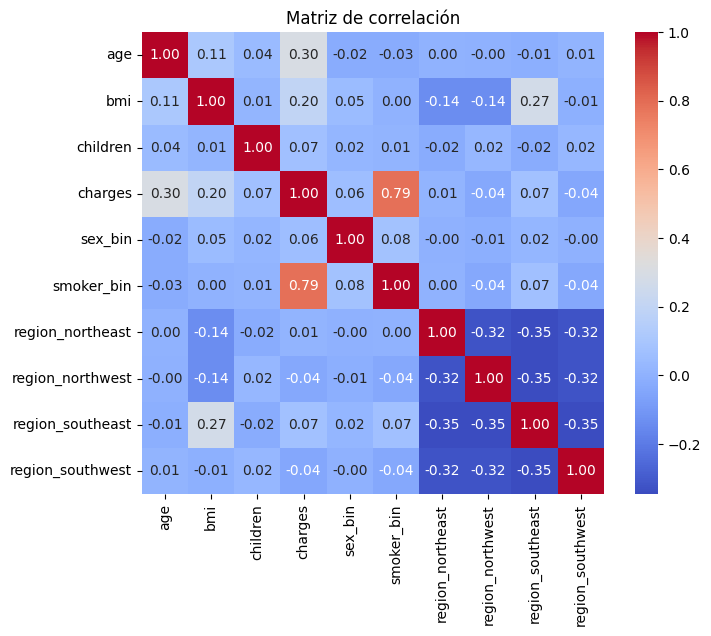

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Solo columnas numéricas
corr = df_limpio.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación")

In [88]:
df_limpio['children_sex'] = df_limpio['children'] * df_limpio['sex_bin']

X = df_limpio[['age', 'bmi', 'children', 'sex_bin', 'smoker_bin', 'children_sex']]
y = df_limpio['charges']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     664.5
Date:                Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:34:26   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1331   BIC:                         2.715e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.204e+04    961.038    -12.529   